In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous

class frechet_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [2]:
# here we are able to sample rv exactly as in publication
N, beta = 1000,  1/2 # run with n = 1000000
# beta = 1/2 because we want to have a finite mean and for this beta we could check that the code is good
r = frechet.rvs(beta, size=N)
# np.mean(r)
# + histogram of data's

In [3]:
from prettytable import PrettyTable
m = 3 # how much we round
t = PrettyTable(['pr.distr.', 'mean', 'sd', '92.5%', '95%', '97.5%', '99%', '99.9%'])
t.add_row(['Fréchet',
           "%.3f" % round(np.mean(r),m),
           "%.3f" % round(np.std(r),m),
#            "%.3f" % round(np.percentile(r, 2.5),m), 
#            "%.3f" % round(np.percentile(r, 25),m), 
#            "%.3f" % round(np.percentile(r, 50),m), 
           "%.3f" % round(np.percentile(r, 92.5),m), 
           "%.3f" % round(np.percentile(r, 95),m), 
           "%.3f" % round(np.percentile(r, 97.5),m), 
           "%.3f" % round(np.percentile(r, 99),m),
           "%.3f" % round(np.percentile(r, 99.9),m)])
# t.add_row(['Bob', 19])
print(t)

+-----------+-------+-------+-------+-------+-------+-------+--------+
| pr.distr. |  mean |   sd  | 92.5% |  95%  | 97.5% |  99%  | 99.9%  |
+-----------+-------+-------+-------+-------+-------+-------+--------+
|  Fréchet  | 1.628 | 1.604 | 3.408 | 4.014 | 5.306 | 7.052 | 15.706 |
+-----------+-------+-------+-------+-------+-------+-------+--------+


In [4]:
# we need a function to get a excesses
def k_greatest_values(a,k):
    """returns k greatest elements from the list and k-1 value starting from which we consider values to be extreme"""
    u = np.sort(a, axis=None)[-1-k]
    a = np.sort(a, axis=None)[-1-k+1:]
    a = asarray([a-u for x in a])
    return(a[1].tolist(), u) # u the starting value from which we consider others as excesses

In [5]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      //return -(1+1/c)*log(1+c*y2);
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  }
  // above distribution is a special case of the distribution in the paper for alpha = beta = 1 / c
  // c = 1/beta
}
data { 
  int N;
  real y[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //real c; 
  real alpha;
  real beta;
}
model {
  // Priors
  // no priors - we assume improper priors on params
  // c ~ uniform(0,1);
  alpha ~ gamma(2,2);
  beta ~ gamma(2,2);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }

}
generated quantities{}
"""

In [7]:
Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
  
// to recover more general distribution of Fisher parametrized by three parameters we need to multiply the above distribution 
// by: df1**df1/2
// we have alpha1,2 = df1,2/2, beta = df2/df1
}

data { 
  int N;
  real y[N]; // points sampled from fisher in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  //parameters of the Fisher
  //real df1;
  //real df2;
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta;
  
}
model {
  // when we deliberately do not specify priors then Stan works with improper priors
  alpha1 ~ gamma(2,2);
  alpha2 ~ gamma(2,2);
  beta ~ gamma(2,2);
   // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}

generated quantities{}
"""

In [ ]:
traceplot_beta_GPD = list(fit.extract().values())[1].tolist() 
traceplot_alpha = list(fit.extract().values())[0].tolist()
traceplot_gamma = np.divide(np.ones(len(traceplot_alpha)), traceplot_alpha)
beta_GPD = np.mean(list(fit.extract().values())[1].tolist())
alpha = np.mean(list(fit.extract().values())[0].tolist())
gamma = 1 / alpha 
print(" alpha = ", alpha, "\n beta = ", beta, "\n gamma = ", gamma)

In [ ]:
traceplot_beta = list(fit.extract().values())[2].tolist()
traceplot_alpha1 = list(fit.extract().values())[1].tolist()
traceplot_alpha2 = list(fit.extract().values())[0].tolist()
beta = np.mean(list(fit.extract().values())[2].tolist())
alpha2 = np.mean(list(fit.extract().values())[1].tolist())
alpha1 = np.mean(list(fit.extract().values())[0].tolist())
print(" alpha1 = ", alpha1, "\n alpha2 = ", alpha2, "\n beta = ", beta)


In [20]:
jump_excesses = np.linspace(5, N/4, 20).astype(int) # astype function converts the values in the array to integers
# jump_excesses = np.range(5, N/2, 5)

q = [0.925, 0.95, 0.975, 0.99, 0.999]
# print(quant_GPD)

quant_GPD = np.zeros(len(jump_excesses)) 

for i in range(len(jump_excesses)):
    frechet, u = k_greatest_values(r, jump_excesses[i])
    data = dict(N = jump_excesses[i],  y = frechet)
    fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
    beta_GPD = np.mean(list(fit.extract().values())[1].tolist()) 
    gamma = 1/np.mean(list(fit.extract().values())[0].tolist())
    quant_GPD[i] = u + beta_GPD*( pow( N * (1-q[0]) / jump_excesses[i], -gamma ) - 1 )

print(quant_GPD)

#we see values for a fixed quantiles

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5551b5fb5994a23fc671300ba4c16b27 NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5551b5fb5994a23fc671300ba4c16b27 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5551b5fb5994a23fc671300ba4c16b27 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5551b5fb5994a23fc671300ba4c16b27 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5551b5fb5994a23fc671300ba4c16b27 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5551b5fb5994a23fc671300ba4c16b27 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5551b5fb5994a23fc671300ba4c16b27 NOW.
INFO:pystan:COMPILING THE C

[8.18058552 4.31604986 4.01129814 3.74944492 3.45329348 3.44408325
 3.40287295 3.33785399 3.32256703 3.3111926  3.31556212 3.32601644
 3.32622453 3.33612896 3.34917158 3.34113409 3.33132109 3.32943494
 3.32160381 3.31508248]


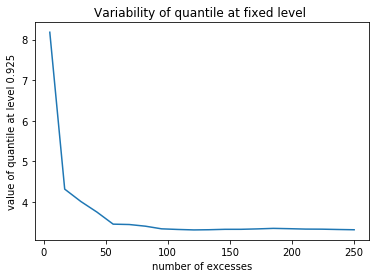

In [21]:
plt.plot(jump_excesses, quant_GPD)
plt.xlabel('number of excesses')
plt.ylabel('value of quantile at level 0.925')
plt.title('Variability of quantile at fixed level ')
plt.show()

In [14]:
# the same for Fischer distribution 
from scipy.stats import f


In [22]:
quant_Fischer = np.zeros(len(jump_excesses)) 

for i in range(len(jump_excesses)):
    frechet, u = k_greatest_values(r, jump_excesses[i])
    data = dict(N = jump_excesses[i],  y = frechet)
    fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) #we sample from the provided data ;
    beta = np.mean(list(fit.extract().values())[2].tolist())
    alpha2 = np.mean(list(fit.extract().values())[1].tolist())
    alpha1 = np.mean(list(fit.extract().values())[0].tolist())
    beta0 = alpha2/alpha1
    quant_Fischer[i] = u + beta0 / beta * f.isf(N / jump_excesses[i] * (1-q[0]), 2 * alpha1, 2 * alpha2, loc=0, scale=1)

print(quant_Fischer)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5 NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d4729f2aae7e8246b7fdb2f0d877cfb5 NOW.
INFO:pystan:COMPILING THE C

[       nan        nan        nan        nan        nan        nan
 3.4049163  3.36669215 3.30572412 3.27187435 3.20241851 3.24689672
 3.20943312 3.25690178 3.23865932 3.24328245 3.35741164 3.46827873
 3.52701751 3.64803486]


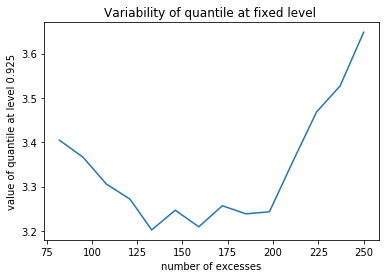

In [23]:
plt.plot(jump_excesses, quant_Fischer)
plt.xlabel('number of excesses')
plt.ylabel('value of quantile at level 0.925')
plt.title('Variability of quantile at fixed level ')
plt.show()